# Линейный классификатор Softmax 

Для выполнения этого задания нужно будет дописать код в этом ноутбуке и внешнем файле classifiers/softmax.py 

Как и в упражнении с классификатором SVM, вам предстоит:

- реализовать векторизованную функцию потерь (**loss**) для Softmax классификатора
- реализовать векторизованную функцию для вычисления **аналитического градиента**
- **проверить свою реализацию** с градиентом, вычисленным методом конечных разностей
- **найти лучшие learning rate и regularization** с помощью валидационной выборки
- **оптимизировать** функцию потерь с помощью градиентного спуска **SGD**
- **визуализировать** матрицу оптимальных весов.


In [1]:
!git clone https://github.com/balezz/tad_ml_dl_2021.git

Cloning into 'tad_ml_dl_2021'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.


In [2]:
!cd tad_ml_dl_2021/Assignment2
import os
os.chdir('tad_ml_dl_2021/Assignment2')
os.getcwd()

'/content/tad_ml_dl_2021/Assignment2'

In [3]:
# Подготовка к работе, импорт библиотек
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Изображения нужно отображать в ноутбуке.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Автоматическая перезагрузка модулей из файлов *.py
%load_ext autoreload
%autoreload 2

In [4]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz 

--2021-03-08 14:15:09--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  50.1MB/s    in 3.6s    

2021-03-08 14:15:13 (45.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
!ls

A2.csv		     cifar-10-python.tar.gz  README.MD	       softmax-ru.ipynb
cifar-10-batches-py  lib		     requirements.txt  svm-ru.ipynb


In [6]:
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Загрузка датасета CIFAR-10 и нормализация данных.
    Алгоритм такой же как в упражнении с SVM, только обернут в функцию.  
    """
    cifar10_dir = './cifar-10-batches-py'
    
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Вызов функции для получения подвыборок train, val, test, dev.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `lib/classifiers/softmax.py`.


In [8]:
!git clone https://github.com/KarinaMusina/kavamu

Cloning into 'kavamu'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 77 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [9]:
!cd kavamu/Assignment2
import os
os.chdir('kavamu/Assignment2')

In [10]:
# Реализуйте функцию вычисления softmax loss в файле classifiers/softmax.py
# с помощью циклов
from softmax import softmax_loss_naive
import time

# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Проверим правильность реализации
# Для 10 классов loss должен быть около -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 0.003550
sanity check: 2.302585


**Вопрос 1**

Объясните, почему мы предположили, что для 10 классов при весах близких к нулю
 softmax loss приблизительно равен -log(0.1)?  
$\color{blue}{\textit Ответ:}$ мы не выполняем процесс обучения, поэтому изначально все классы будут выбраны с одинаковой вероятностью. В CIFAR-10 у нас есть 10 классов, поэтому вероятность правильного класса будет 0,1, а softmax loss - это отрицательная логарифмическая вероятность правильного класса, поэтому это -log (0,1).



In [11]:
# Дополните функцию softmax_loss_naive вычислением градиента dW
# с помощью вложенных циклов.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как и в упражнении с SVM, используем метод конечных разностей для проверки.
from lib.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Тест должен быть пройден и при ненулевой регуляризации
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.012588 analytic: 0.012588, relative error: 4.740218e-08
numerical: -0.018447 analytic: -0.018447, relative error: 4.142753e-08
numerical: -0.005882 analytic: -0.005882, relative error: 9.614143e-09
numerical: -0.004932 analytic: -0.004932, relative error: 3.021362e-09
numerical: -0.002233 analytic: -0.002233, relative error: 2.049083e-09
numerical: 0.052824 analytic: 0.052824, relative error: 9.472925e-10
numerical: -0.008121 analytic: -0.008121, relative error: 1.146592e-08
numerical: -0.002129 analytic: -0.002129, relative error: 2.035426e-09
numerical: -0.015312 analytic: -0.015312, relative error: 6.504973e-08
numerical: 0.143130 analytic: 0.143130, relative error: 6.962698e-09
numerical: -0.004173 analytic: -0.004173, relative error: 2.104179e-07
numerical: -0.009140 analytic: -0.009140, relative error: 7.633058e-08
numerical: -0.006315 analytic: -0.006315, relative error: 4.165338e-08
numerical: 0.017409 analytic: 0.017409, relative error: 9.131354e-08
numerical: -0.

In [12]:
# Теперь реализуем более эффективную векторизованную версию функции вычисления loss и dW
# Оценим, насколько быстрее стали вычисления
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Для оценки близости двух матриц градиентов используем норму Фробениуса
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 3.550209e-03 computed in 0.149383s
vectorized loss: 2.349311e+00 computed in 0.019268s
Loss difference: 2.345761
Gradient difference: 392.147004


In [13]:
X_train.shape[0]

49000

In [14]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.35 на выборке val.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (training_accuracy, validation_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
from linear_classifier1 import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на валидационной        #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор Softmax          #
# на train выборке, вычислите точность на выборках train, val и сохраните             #
# результат в словарь results. Лучшее значение точности сохраните в best_val           #
# лучший классификатор - в best_softmax                                           #
#                                                                              #
# Подсказка: чтобы уменьшить время обучения, используйте dev подвыборку.                #
# После того, как код будет реализован и отлажен, замените dev на train.              #
################################################################################



# Пример допустимых значений. Можете изменить на свое усмотрение.
learning_rates = [1e-7, 2e-6, 2.5e-6]
regularization_strengths = [1e3, 1e4, 2e4, 2.5e4, 3e4, 3.5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [ (lr, rg) for lr in learning_rates for rg in regularization_strengths]

for lr, rg in grid_search:
    # Create a new Softmax instance
    softmax_model = Softmax()
    # Train the model with current parameters
    softmax_model.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=554)
    # Predict values for training set
    y_train_pred = softmax_model.predict(X_train)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = softmax_model.predict(X_val)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_softmax = softmax_model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Вывод результатов.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.204245 val accuracy: 0.200000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.262245 val accuracy: 0.261000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.300673 val accuracy: 0.310000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.315122 val accuracy: 0.331000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.315184 val accuracy: 0.338000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.312388 val accuracy: 0.328000
lr 2.000000e-06 reg 1.000000e+03 train accuracy: 0.391041 val accuracy: 0.403000
lr 2.000000e-06 reg 1.000000e+04 train accuracy: 0.337653 val accuracy: 0.336000
lr 2.000000e-06 reg 2.000000e+04 train accuracy: 0.319469 val accuracy: 0.345000
lr 2.000000e-06 reg 2.500000e+04 train accuracy: 0.321776 val accuracy: 0.350000
lr 2.000000e-06 reg 3.000000e+04 train accuracy: 0.291000 val accuracy: 0.293000
lr 2.000000e-06 reg 3.500000e+04 train accuracy: 0.274776 val accuracy: 0.282000
lr 2.500000e-06 reg 1.000000

In [15]:
# Точность на test выборке
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.370000


**Вопрос 2** - *Да или Нет*

Суммарное значение функции потерь (loss) на всей train выборке равно сумме потерь для каждого отсчета. Существует такой отсчет (изображение), который можно добавить в train выборку, при этом значение loss для SVM классификатора не изменится. Для Softmax классификатора такого отсчета не существует.    
  
$\color{blue}{\textit Ответ:}$ Да


$\color{blue}{\textit Объясните:}$ 

Предположим, что мы добавляем новую точку данных, которая приводит к баллам [5,4,2], а также что запас для SVM равен 1, а правильный класс равен 1, тогда потеря SVM этой точки данных будет равна 0, потому что она удовлетворяет запасу , т.е. max (0, 4 + 1 - 5) + max (0, 2 + 2 - 5) = 0. Таким образом, потери не меняются. 
Однако для классификатора Softmax это не тот случай, когда потери увеличиваются, то есть -log (softmax (5)) = -log (0,7) = 0,35. 



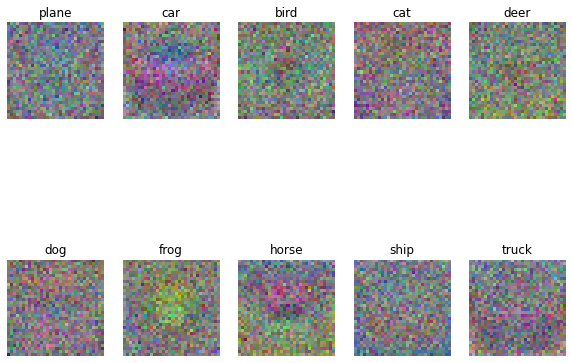

In [16]:
# Визуализируем веса W для каждого класса
w = best_softmax.W[:-1,:] # отбросим фиктивное измерение bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# ПОЗДРАВЛЯЕМ!

Это конец задания. Не забудьте сохранить этот ноутбук и файл softmax.py